In [1]:
import os
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
pd.set_option('mode.use_inf_as_na', True)

In [2]:
import matplotlib.pyplot as plt

In [3]:
DATA = '../'
DATASET = os.path.abspath(DATA) + '/EnterpriseDNA_Challenge 18.xlsx'

### Read Data

In [4]:
dict_df = pd.read_excel(DATASET, sheet_name=None)
print(dict_df.keys())

dict_keys(['Fact', 'Target Speeds', 'Product', 'Machine', 'Glossary'])


### 1. Data Cleansing - "Fact" table

In [5]:
df = dict_df.get('Fact')
df.sort_values(['Machine','Product', 'StartDateTime'], inplace=True)
df.rename(columns={'TotalBiscuitsMade':'TotalMadeBiscuits'}, inplace=True)
df.head(2)

,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product
413,Biscuit Boxing Machine,2021-07-02 05:39:06,2021-07-02 14:52:37,553.512024,0,40,NO (No Order),Bourbon Creams
479,Biscuit Boxing Machine,2021-07-02 14:52:37,2021-07-02 14:53:08,0.516667,0,196,CC (Changeover Cleaning),Bourbon Creams


In [6]:
# 1. If Good Made > Total Made then Total = Good Made 
df ['TotalMadeBiscuits'] = np.where (df ['TotalMadeBiscuits'] < df ['GoodMadeBiscuits'], df ['GoodMadeBiscuits'], df ['TotalMadeBiscuits'])
df.head(2)

,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product
413,Biscuit Boxing Machine,2021-07-02 05:39:06,2021-07-02 14:52:37,553.512024,40,40,NO (No Order),Bourbon Creams
479,Biscuit Boxing Machine,2021-07-02 14:52:37,2021-07-02 14:53:08,0.516667,196,196,CC (Changeover Cleaning),Bourbon Creams


In [7]:
def compute_outliers_IQR(df_col):
    q1=df_col.quantile(0.25)   
    q3=df_col.quantile(0.75)
    IQR=q3-q1
    upper = df_col[~(df_col>(q3+1.5*IQR))].max()
    lower = df_col[~(df_col<(q1-1.5*IQR))].min()
    return upper, lower

In [8]:
# 2. Clean Accumulate Biscuits

### - Difference between consecutive rows
df['KEY'] = df.apply(lambda x: '{}|{}'.format(x['Machine'],x['Product']),axis=1)
lst_key = df['KEY'].unique().tolist()
df_final = pd.DataFrame()
for key in lst_key:
    df_key = df[df['KEY']==key]
    for i in ['Total', 'Good']:
        df_key[f'{i}_Dif'] = df_key.groupby(['KEY'])[f'{i}MadeBiscuits'].diff()
        df_key[f'{i}_GapDif'] = df_key[f'{i}_Dif']/df_key[f'{i}MadeBiscuits']
    df_final = df_final.append(df_key)

(0.0, 1500.0)

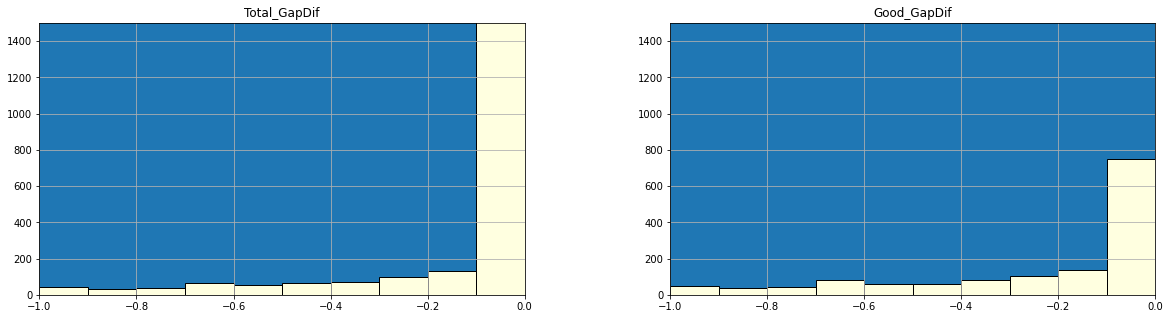

In [9]:
df_TotalNegative = df_final[df_final[f'Total_GapDif'] < 0]
df_GoodNegative = df_final[df_final[f'Good_GapDif'] < 0]
fig, axes = plt.subplots(1,2,figsize = (20, 5),gridspec_kw={'width_ratios': [2,2]})
df_TotalNegative.hist('Total_GapDif', ax=axes[0])
df_GoodNegative.hist('Good_GapDif', ax=axes[1])
axes[0].hist(df_TotalNegative['Total_GapDif'], bins = 10, color = 'lightyellow', edgecolor='black', range=[-1, 0]) 
axes[1].hist(df_TotalNegative['Good_GapDif'], bins = 10,  color = 'lightyellow', edgecolor='black', range=[-1, 0]) 
axes[0].set_xlim(xmin=-1, xmax = 0)
axes[0].set_ylim(ymin=0, ymax = 1500)
axes[1].set_xlim(xmin=-1, xmax = 0)
axes[1].set_ylim(ymin=0, ymax = 1500)

In [10]:
for i in ['Total', 'Good']:
    df_NegativeDif = df_final[df_final[f'{i}_GapDif'] < 0]
    upper, lower = compute_outliers_IQR(-df_NegativeDif[f'{i}_GapDif'])
    df_final[f'{i}_DifUpper'] = -0.1
    df_final[f'{i}_FixDif'] = np.where((df_final[f'{i}_GapDif']<0) & (df_final[f'{i}_GapDif'] > df_final[f'{i}_DifUpper']), 
                                    0, df_final[f'{i}_Dif'])
df = df_final.copy()
df.head(2)

,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product,KEY,Total_Dif,Total_GapDif,Good_Dif,Good_GapDif,Total_DifUpper,Total_FixDif,Good_DifUpper,Good_FixDif
413,Biscuit Boxing Machine,2021-07-02 05:39:06,2021-07-02 14:52:37,553.512024,40,40,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,NaN,NaN,NaN,NaN,-0.1,NaN,-0.1,NaN
479,Biscuit Boxing Machine,2021-07-02 14:52:37,2021-07-02 14:53:08,0.516667,196,196,CC (Changeover Cleaning),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,156.0,0.795918,156.0,0.795918,-0.1,156.0,-0.1,156.0


In [11]:
### - If dif < 0 (amount decreases), then dif = Original Value | If dif is NaN (first row of group), dif = TotalMade
### - Cumsum dif to return a new TotalBiscuitsMade

for i in ['Total', 'Good']:
    df[f'{i}_FinalDif'] = np.where(df[f'{i}_FixDif'] < 0, df[f'{i}MadeBiscuits'], df[f'{i}_FixDif'])
    df[f'{i}_FinalDif'] = np.where(np.isnan(df[f'{i}_FinalDif']), df[f'{i}MadeBiscuits'], df[f'{i}_FinalDif'])
    df[f'{i}_Final'] = df.groupby(['KEY'])[f'{i}_FinalDif'].cumsum()
df.head(2)

,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product,KEY,Total_Dif,...,Good_Dif,Good_GapDif,Total_DifUpper,Total_FixDif,Good_DifUpper,Good_FixDif,Total_FinalDif,Total_Final,Good_FinalDif,Good_Final
413,Biscuit Boxing Machine,2021-07-02 05:39:06,2021-07-02 14:52:37,553.512024,40,40,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,NaN,...,NaN,NaN,-0.1,NaN,-0.1,NaN,40.0,40.0,40.0,40.0
479,Biscuit Boxing Machine,2021-07-02 14:52:37,2021-07-02 14:53:08,0.516667,196,196,CC (Changeover Cleaning),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,156.0,...,156.0,0.795918,-0.1,156.0,-0.1,156.0,156.0,196.0,156.0,196.0


In [12]:
# 3. Start/End Stoppage Timing
df['Total_ExtraBiscuits'] = df.groupby(['KEY'])['Total_Final'].diff()
df_tg = dict_df.get('Target Speeds')
df_tg['Target_per_min'] = df_tg['TARGET_Biscuits_per_hour']/60
df = df.merge(df_tg, how='left', on=['Machine', 'Product'])
df['Produce_Duration'] = df['Total_ExtraBiscuits'] / df['Target_per_min']
df['Cleaned_Duration'] = np.where(df['Produce_Duration'] > df['Duration'], df['Duration']/2, df['Duration']-df['Produce_Duration'])
df['Cleaned_Duration'] = df['Cleaned_Duration'].fillna(0)
df['Cleaned_End time'] = df.apply(lambda x: x['StartDateTime'] + pd.Timedelta(minutes=x['Cleaned_Duration']),axis=1)
df.head()

,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product,KEY,Total_Dif,...,Total_FinalDif,Total_Final,Good_FinalDif,Good_Final,Total_ExtraBiscuits,TARGET_Biscuits_per_hour,Target_per_min,Produce_Duration,Cleaned_Duration,Cleaned_End time
0,Biscuit Boxing Machine,2021-07-02 05:39:06,2021-07-02 14:52:37,553.512024,40,40,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,NaN,...,40.0,40.0,40.0,40.0,NaN,51840,864.0,NaN,0.000000,2021-07-02 05:39:06.000000
1,Biscuit Boxing Machine,2021-07-02 14:52:37,2021-07-02 14:53:08,0.516667,196,196,CC (Changeover Cleaning),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,156.0,...,156.0,196.0,156.0,196.0,156.0,51840,864.0,0.180556,0.336111,2021-07-02 14:52:57.166666
2,Biscuit Boxing Machine,2021-07-02 14:53:08,2021-07-02 14:53:58,0.833333,369,369,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,173.0,...,173.0,369.0,173.0,369.0,173.0,51840,864.0,0.200231,0.633102,2021-07-02 14:53:45.986110
3,Biscuit Boxing Machine,2021-07-02 14:53:58,2021-07-02 14:54:32,0.566700,137,137,CC (Changeover Cleaning),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,-232.0,...,137.0,506.0,137.0,506.0,137.0,51840,864.0,0.158565,0.408135,2021-07-02 14:54:22.488110
4,Biscuit Boxing Machine,2021-07-02 14:54:32,2021-07-02 15:26:01,31.484266,351,351,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,214.0,...,214.0,720.0,214.0,720.0,214.0,51840,864.0,0.247685,31.236581,2021-07-02 15:25:46.194866


In [13]:
def clean_split_time_end(row):
    if row['Position']==0:
        d = row['StartDateTime'].day
        m = row['StartDateTime'].month
        y = row['StartDateTime'].year
        res = datetime(year=y, month=m, day=d, hour=23, minute=59, second=59)
    else:
        new = row['StartDateTime'] + pd.Timedelta(days=row['Position'])
        d = new.day
        m = new.month
        y = new.year
        res = datetime(year=y, month=m, day=d, hour=23, minute=59, second=59)
    return res

In [14]:
def clean_split_time_start(row):
    if row['Position']==0:
        res = row['StartDateTime']
    else:
        new = row['StartDateTime'] + pd.Timedelta(days=row['Position'])
        d = new.day
        m = new.month
        y = new.year
        res = datetime(year=y, month=m, day=d, hour=0, minute=0, second=1)
    return res

In [15]:
# 4. Split line by Day
df['Day_diff'] = (df['Cleaned_End time'] - df['StartDateTime']).dt.days
df_overflow = df[df['Day_diff'] >= 1]
df_ok = df[df['Day_diff'] == 0]     # no line < 0

# - Explode, keep the same volume produced
df_explode = df_overflow[df_overflow['Produce_Duration'] <= df_overflow['Cleaned_Duration']]
df_explode['KEY_SPLIT'] = df_explode.apply(lambda x: '{}|{}|{}'.format(x['KEY'],x['StartDateTime'],x['Cleaned_End time']),axis=1)
df_explode = df_explode.drop_duplicates(subset='KEY_SPLIT', keep='first')
df_explode = (df_explode.loc[df_explode.index.repeat(df_explode['Day_diff'])]
              .reset_index(drop=True)
              .assign(Position=lambda d: d.groupby('KEY_SPLIT').cumcount())
              )
df_explode['Final_End time'] = df_explode.apply(lambda x: clean_split_time_end(x), axis=1)
df_explode['Final_Start time'] = df_explode.apply(lambda x: clean_split_time_start(x), axis=1)
df_explode['Remark'] = 'Explode Line by Day'

df_explode.head(2)


,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product,KEY,Total_Dif,...,Target_per_min,Produce_Duration,Cleaned_Duration,Cleaned_End time,Day_diff,KEY_SPLIT,Position,Final_End time,Final_Start time,Remark
0,Biscuit Boxing Machine,2021-07-29 07:10:34,2021-08-22 20:02:41,35332.121094,132,132,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,-358.0,...,864.0,0.152778,35331.968316,2021-08-22 20:02:32.098958,24,Biscuit Boxing Machine |Bourbon Creams|2021-07...,0,2021-07-29 23:59:59,2021-07-29 07:10:34,Explode Line by Day
1,Biscuit Boxing Machine,2021-07-29 07:10:34,2021-08-22 20:02:41,35332.121094,132,132,NO (No Order),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,-358.0,...,864.0,0.152778,35331.968316,2021-08-22 20:02:32.098958,24,Biscuit Boxing Machine |Bourbon Creams|2021-07...,1,2021-07-30 23:59:59,2021-07-30 00:00:01,Explode Line by Day


In [16]:
# - Concat
df_noexplode = df_overflow[df_overflow['Produce_Duration'] > df_overflow['Cleaned_Duration']]
df = pd.concat([df_explode, df_noexplode, df_ok])
df['Final_Start time'] = df['Final_Start time'].fillna(df['StartDateTime'])
df['Final_End time'] = df['Final_End time'].fillna(df['Cleaned_End time'])
df['Final_Duration'] = (df['Final_End time'] - df['Final_Start time']).dt.total_seconds() / 60         # to compare with int

In [17]:
# 5. OEE Category
cond_NoOrder = df['OEE Category'].isin([0, '0', '0.0', 'NO (No Order)'])
cond_LargeDuration = df['Duration'] >= 720
cond_SmallDuration = df['Duration'] < 720
df.loc[cond_NoOrder & cond_LargeDuration, 'OEE Category'] = 'SL (Schedule Loss)'
df.loc[cond_NoOrder & cond_SmallDuration, 'OEE Category'] = 'AL (Other Availability Loss)'
df.head(2)

,Machine,StartDateTime,EndDateTime,Duration,TotalMadeBiscuits,GoodMadeBiscuits,OEE Category,Product,KEY,Total_Dif,...,Produce_Duration,Cleaned_Duration,Cleaned_End time,Day_diff,KEY_SPLIT,Position,Final_End time,Final_Start time,Remark,Final_Duration
0,Biscuit Boxing Machine,2021-07-29 07:10:34,2021-08-22 20:02:41,35332.121094,132,132,SL (Schedule Loss),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,-358.0,...,0.152778,35331.968316,2021-08-22 20:02:32.098958,24,Biscuit Boxing Machine |Bourbon Creams|2021-07...,0.0,2021-07-29 23:59:59,2021-07-29 07:10:34,Explode Line by Day,1009.416667
1,Biscuit Boxing Machine,2021-07-29 07:10:34,2021-08-22 20:02:41,35332.121094,132,132,SL (Schedule Loss),Bourbon Creams,Biscuit Boxing Machine |Bourbon Creams,-358.0,...,0.152778,35331.968316,2021-08-22 20:02:32.098958,24,Biscuit Boxing Machine |Bourbon Creams|2021-07...,1.0,2021-07-30 23:59:59,2021-07-30 00:00:01,Explode Line by Day,1439.966667


In [18]:
# 5. Major & Minor stoppages
df.loc[df['Final_Duration']<=3, 'Stoppage'] = 'Minor Stoppage'
df.loc[df['Final_Duration']>3, 'Stoppage'] = 'Major Stoppage'

In [19]:
# 6. Convert product units
df.sort_values(['Machine','Product', 'Final_Start time'], inplace=True)
df = df.reset_index(drop=True)
df['Final_Total Produced'] = df.groupby(['KEY'])['Total_Final'].diff().fillna(df['Total_Final'])
df['Final_Good Produced'] = df.groupby(['KEY'])['Good_Final'].diff().fillna(df['Good_Final'])

case_unit = ['Biscuit Boxing Machine', 'Packaging Heat Machine']
df['Machine'] = df['Machine'].str.strip()
# Merge with Product Master
df_product = dict_df.get('Product')
df_product = df_product.rename(columns={'Product Name':'Product'})
df = df.merge(df_product, how='left', on='Product')
df.loc[df['Machine'].isin(case_unit), 'Final_Total Produced'] = df['Final_Total Produced']*df['Biscuits_PER_CASE']
df.loc[df['Machine'].isin(case_unit), 'Final_Good Produced'] = df['Final_Good Produced']*df['Biscuits_PER_CASE']

In [20]:
df.to_excel(DATA + 'Cleaned_FACT.xlsx', index=False)